In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


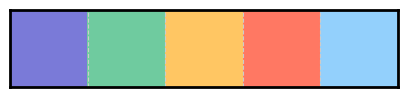

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': True, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusive range in python


In [67]:
#path = "/home/alena/source/growe/exps8"

folder = "expfinalfinal"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


In [80]:

def process_cov_data(path: str) -> List[str]:
    with open(path,encoding="utf8") as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    data['valid_inputs_percent']= data['valid_inputs'] / data['total_inputs']

    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()

    data['rolling_algorithm'] = data['algorithm'].astype(str) + f"_rollingmean_{rolling}"
    
    return data

In [82]:
def p2f(value: str) -> float:
    return float(value.strip('%'))

def read_plot_data(path: str, algorithm: str, idx: int) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
  
    if algorithm != "afl":
        data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
        data['valid_inputs_percent']= (data['valid_inputs'] / data['total_inputs'])

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
    if algorithm != "afl":
        algo_data[['generator','guidance']] = algo_data['algorithm'].str.split('-', expand=True)

    algo_data['run'] = [idx] * algo_data.shape[0]
  
    return algo_data


## READ ORIGINAL DATA

In [83]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes

for algorithm in ALGORITHM:
    original_data_per_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm,idx)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
        
    original_plot_data.extend([d for d in original_data_per_algo])



In [84]:

def read_exception_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'exception_log.csv')
    #print(ps)
    columns=["exception","unique","count","file","empty"]
    if algorithm != "afl":
        data = pd.read_csv(ps, sep=";", header=None,names=columns)

    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [85]:
def read_exceptions_from_jqf_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'jqf.log')
    #print(ps)
    columns=["exception","count"]
    data={
        "exception":[]
    }
    lines = process_cov_data(ps)
    for l in lines:
        if "ERROR" in l:
            ex = l.replace("ERROR ~ ","")
            data["exception"].append(ex.split(":")[0].strip())
    #print(data)
    data = pd.DataFrame(data)
    
    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [86]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
        if not algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
            if os.path.exists(os.path.join(path,"exception_log.csv")): 
                exc = read_exception_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
        else : 
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}")
            #print(os.path.join(path,"jqf.log"))
            if os.path.exists(os.path.join(path,"jqf.log")): 
                exc = read_exceptions_from_jqf_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)



In [87]:
a = exceptions_data

pd.set_option('display.max_rows', 30)
b=a[ a['algorithm'] == 'afl']  
b

,exception,unique,count,file,empty,algorithm,run
0,Script compilation error,NaN,NaN,NaN,NaN,afl,0
1,Script compilation error,NaN,NaN,NaN,NaN,afl,0
2,Script compilation error,NaN,NaN,NaN,NaN,afl,0
3,Script compilation error,NaN,NaN,NaN,NaN,afl,0
4,Script compilation error,NaN,NaN,NaN,NaN,afl,0
...,...,...,...,...,...,...,...
4068,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4069,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4070,Script compilation error,NaN,NaN,NaN,NaN,afl,19
4071,Script compilation error,NaN,NaN,NaN,NaN,afl,19


## interpolated data

In [104]:
# interpolated data

reindexsteps =5  
interpolate = True

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0
time_range=3600
for df in original_plot_data:
    algorithm = df['algorithm'][0]
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        time_based_data = time_based_data.set_index(x_axis).reindex(
           range(1, time_range, reindexsteps)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
        if algorithm != "afl": time_based_data[['generator','guidance']] = time_based_data['algorithm'].str.split('-', expand=True)

    if algorithm != "afl": time_based_data['valid_inputs_percent']= (time_based_data['valid_inputs'] / time_based_data['total_inputs'])

    time_based_plot_data.append( time_based_data)

    if algorithm == "afl": continue
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        count_based_data = count_based_data.set_index(x_axis).reindex(
           range(1, count_based_data[x_axis].max(), reindexsteps*8)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
        if algorithm != "afl": count_based_data[['generator','guidance']] = count_based_data['algorithm'].str.split('-', expand=True)
        
    count_based_data['valid_inputs_percent']= (count_based_data['valid_inputs'] / count_based_data['total_inputs'])
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
afl_time_based_plot_data = time_based_plot_data[time_based_plot_data['algorithm']=='afl']
time_based_plot_data = time_based_plot_data[time_based_plot_data['algorithm']!='afl']


In [105]:
time_based_plot_data


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
2,11,0.0,0.0,12.000000,0.0,0.0,7666.410000,0.000000,0.0,0.0,...,7.000000,7342.97,19626.000000,18798.000000,19.000000,0.631579,semantic-zest,semantic,zest,0.0
3,16,0.0,0.0,17.333333,0.0,0.0,7838.153333,0.333333,0.0,0.0,...,10.666667,7511.98,20065.666667,19230.666667,30.000000,0.644444,semantic-zest,semantic,zest,0.0
4,21,0.0,0.0,22.666667,0.0,0.0,8009.896667,0.666667,0.0,0.0,...,14.333333,7680.99,20505.333333,19663.333333,41.000000,0.650407,semantic-zest,semantic,zest,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57595,3576,0.0,0.0,30.000000,0.0,0.0,6823.830000,1490.333333,0.0,0.0,...,7833.333333,6544.92,17469.000000,16755.000000,15903.333333,0.507441,syntactic-noguidance,syntactic,noguidance,19.0
57596,3581,0.0,0.0,30.000000,0.0,0.0,6823.830000,1491.666667,0.0,0.0,...,7837.666667,6544.92,17469.000000,16755.000000,15910.666667,0.507395,syntactic-noguidance,syntactic,noguidance,19.0
57597,3586,0.0,0.0,30.000000,0.0,0.0,6823.830000,1493.000000,0.0,0.0,...,7842.000000,6544.92,17469.000000,16755.000000,15918.000000,0.507350,syntactic-noguidance,syntactic,noguidance,19.0
57598,3591,0.0,0.0,30.000000,0.0,0.0,6823.830000,1493.000000,0.0,0.0,...,7842.000000,6544.92,17469.000000,16755.000000,15918.000000,0.507350,syntactic-noguidance,syntactic,noguidance,19.0


## rolling mean data

In [106]:
# rolling mean data

ROLLING_MEAN=50

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)
for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [107]:
complete_data_frame


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,0,0,0,1,0,0,755.47,0,0,0,...,0.0,755.47,1934.0,1934.0,1.0,1.000000,semantic-zest,semantic,zest,0
1,11,0,0,12,0,0,7666.41,0,0,0,...,7.0,7342.97,19626.0,18798.0,19.0,0.631579,semantic-zest,semantic,zest,0
2,15,0,0,16,0,0,7692.19,1,0,0,...,10.0,7349.22,19692.0,18814.0,27.0,0.629630,semantic-zest,semantic,zest,0
3,19,0,0,22,0,0,7985.55,1,0,0,...,16.0,7653.91,20443.0,19594.0,41.0,0.609756,semantic-zest,semantic,zest,0
4,23,0,0,25,0,0,8181.64,1,0,0,...,16.0,7850.00,20945.0,20096.0,48.0,0.666667,semantic-zest,semantic,zest,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119225,581,0,4,12,11,1,3.47,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119226,1165,0,5,12,10,0,3.47,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119227,1953,0,5,13,11,0,3.47,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19
119228,2145,0,10,13,10,0,3.47,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,afl,NaN,NaN,19


In [120]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str, path: str, errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(8,6))
    #ax2 = ax1.twinx()

    lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar=("se", 2), hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    
    '''
    y2=f"rolling_{ROLLING_MEAN}_{y_axis}"
    if not y2 in rolling_data.columns:
        y2 = y_axis
    
    lineplot2 = sns.lineplot(x=x_axis, 
                             y=y2, 
                             hue='rolling_algorithm', 
                             errorbar=None, 
                             hue_order=sorted(rolling_data['rolling_algorithm'].unique()), 
                             data=rolling_data, 
                             ax=ax1, 
                             palette="Set2",
                             linestyle="dotted")
    legend2 = lineplot2.legend()

    leg_lines = legend2.get_lines()
    for line in leg_lines[4:]:
        line.set_linestyle(":")
    
    '''
        
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
    
    lineplot1.set(title=path.split("/")[-1][:-4].replace("_"," "))
   
    # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax1.get_figure()
    fig.show()
    fig.savefig(path)


In [109]:
errorbrar = 'se'
pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))

    

# unix_time valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\4074450924.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


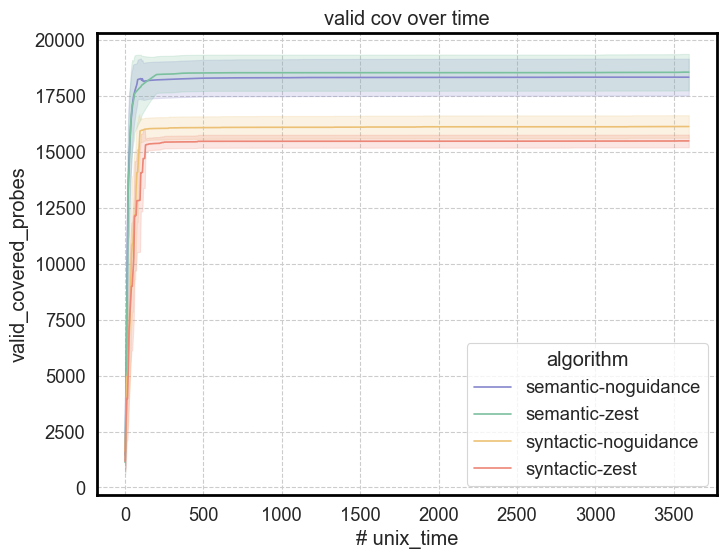

In [121]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes", f"{pdf_dir}valid_cov_over_time.pdf", 'ci')


(-178.75, 3775.75)
(-178.75, 3775.75)


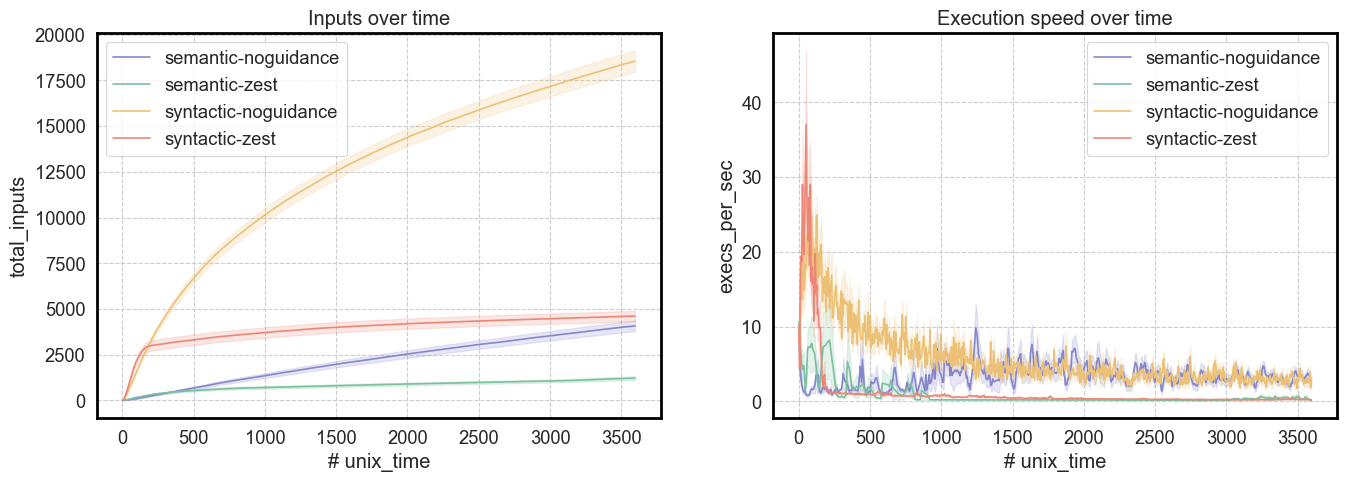

In [111]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='total_inputs', hue='algorithm', errorbar="se", hue_order=sorted(time_based_plot_data['algorithm'].unique()), data=time_based_plot_data, ax=ax1[0])
lineplot1.set_title("Inputs over time")
lineplot1.legend(loc='upper left')
lineplot2 = sns.lineplot(x=x, 
                         y='execs_per_sec', 
                         hue='algorithm', 
                         errorbar="se", 
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("Execution speed over time")
lineplot2.legend(loc='upper right')

print(lineplot1.get_xlim())
print(lineplot2.get_xlim())
path=f"{pdf_dir}/inputs_over_time.pdf"


fig.savefig(path)


# unix_time total_inputs


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\2862732193.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


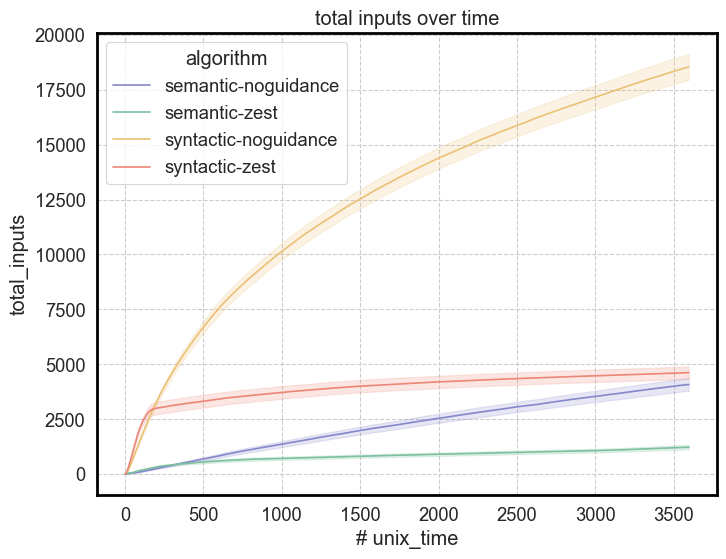

In [112]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs", f"{pdf_dir}total_inputs_over_time.pdf", 'se')


# unix_time execs_per_sec


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\2862732193.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


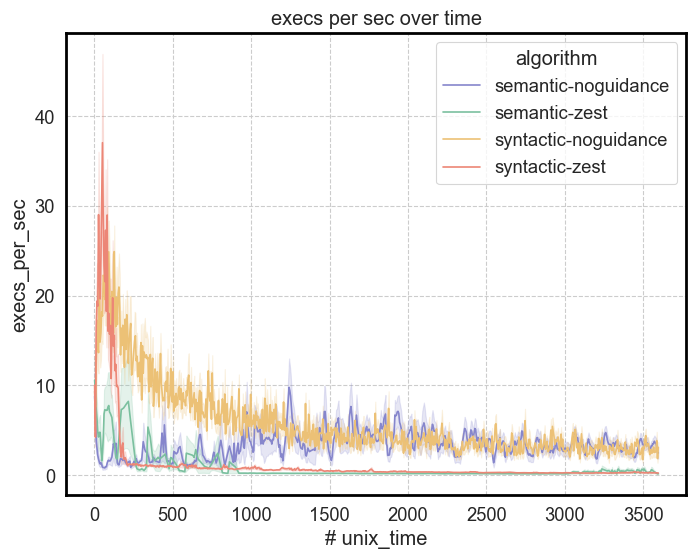

In [113]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "execs_per_sec", f"{pdf_dir}execs_per_sec_over_time.pdf", 'se')


In [114]:
time_based_plot_data.groupby(['run','algorithm'])['execs_per_sec'].first()

run   algorithm           
0.0   semantic-noguidance      1.46
      semantic-zest            0.19
      syntactic-noguidance     3.58
      syntactic-zest           1.45
1.0   semantic-noguidance      2.08
                              ...  
18.0  syntactic-zest           1.26
19.0  semantic-noguidance     17.41
      semantic-zest            0.16
      syntactic-noguidance     5.65
      syntactic-zest           6.56
Name: execs_per_sec, Length: 80, dtype: float64

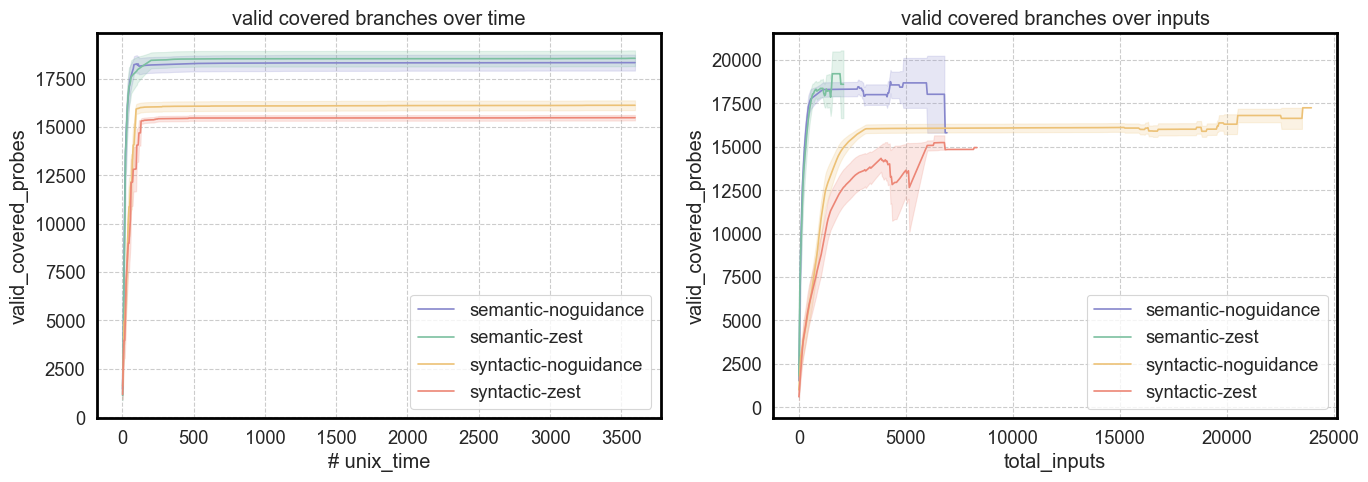

In [115]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='valid_covered_probes', 
                         hue='algorithm',
                         errorbar="se",
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[0])
lineplot1.set_title("valid covered branches over time")
lineplot1.legend(loc='lower right')
x2='total_inputs'
lineplot2 = sns.lineplot(x=x2, 
                         y='valid_covered_probes', 
                         hue='algorithm', 
                         hue_order=sorted(count_based_plot_data['algorithm'].unique()), 
                         errorbar="se",
                         data=count_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("valid covered branches over inputs")
lineplot2.legend(loc='lower right')

#path=f"{pdf_dir}/covered_probes_time_and_inputs.pdf"


fig.savefig(path)


total_inputs valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\2862732193.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


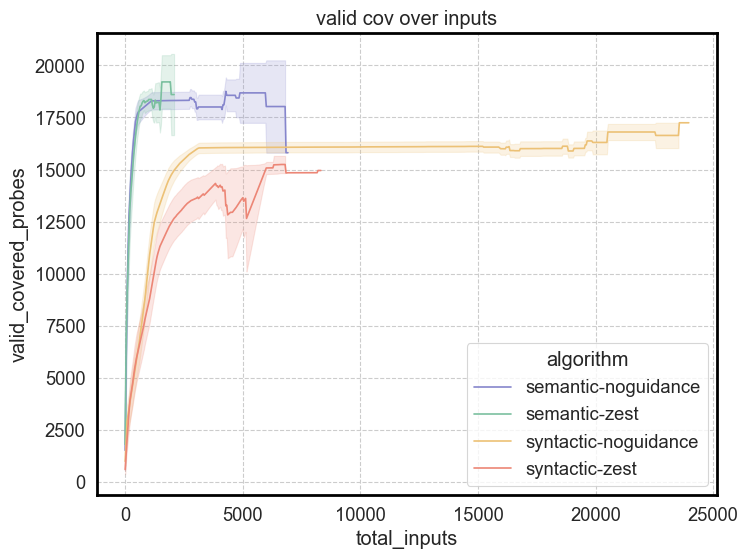

In [99]:

generate_plot_data_base(count_based_plot_data, rolling_time_based_plot_data, "total_inputs", "valid_covered_probes", f"{pdf_dir}valid_cov_over_inputs.pdf", 'se')


In [24]:
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs" , f"{pdf_dir}valid_inputs_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "invalid_inputs" , f"{pdf_dir}invalid_inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs" , f"{pdf_dir}inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}crashes_over_time.pdf", errorbrar)


In [25]:
#sns.pairplot(rolling_time_based_plot_data)

# unix_time valid_inputs_percent


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\2862732193.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


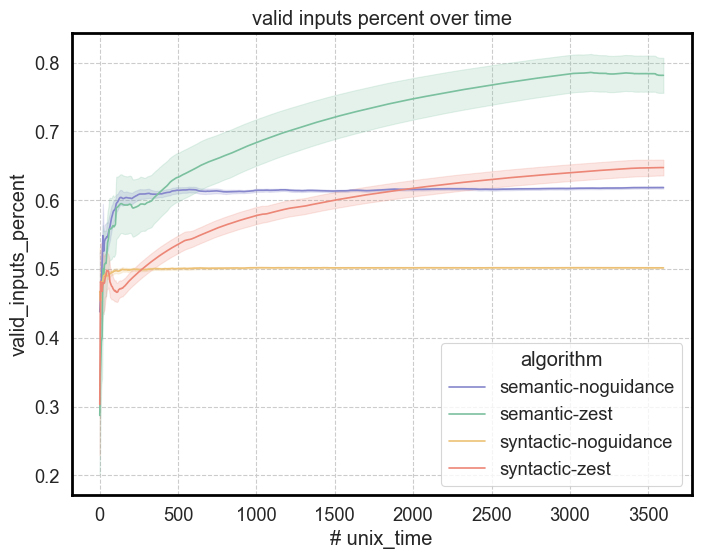

In [100]:
jqf_data = time_based_plot_data[time_based_plot_data['algorithm']!='afl']

generate_plot_data_base(jqf_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs_percent", f"{pdf_dir}valid_inputs_percent_over_time.pdf", errorbrar)
plot.get_figure().savefig(f"{pdf_dir}/valid_inputs_percent_over_time.pdf")


In [27]:
exceptions_data[10:100]


,exception,unique,count,file,empty,algorithm,run
3,nextflow.exception.ScriptCompilationException,True,3,out1695556630854.nf,NaN,semantic-zest,3
4,nextflow.exception.ScriptCompilationException,True,4,out1695556930198.nf,NaN,semantic-zest,3
0,nextflow.exception.AbortRunException,True,1,out1695559943251.nf,NaN,semantic-zest,4
1,nextflow.exception.ScriptCompilationException,True,1,out1695559972002.nf,NaN,semantic-zest,4
2,nextflow.exception.ScriptCompilationException,True,2,out1695560176011.nf,NaN,semantic-zest,4
...,...,...,...,...,...,...,...
16,nextflow.exception.ScriptCompilationException,True,4,out1695396529903.nf,NaN,syntactic-zest,0
17,groovy.lang.MissingPropertyException,True,13,out1695396530378.nf,NaN,syntactic-zest,0
18,groovy.lang.MissingPropertyException,True,14,out1695396531556.nf,NaN,syntactic-zest,0
19,groovy.lang.MissingPropertyException,True,15,out1695396531945.nf,NaN,syntactic-zest,0


In [102]:
for algo in ALGORITHM:
    algo_data = exceptions_data[exceptions_data['algorithm'] == algo]
    #print( algo)
    #print(algo_data['exception'].value_counts())
exceptions_count = exceptions_data.groupby(['exception','algorithm'])['algorithm'].count().to_frame()
print(exceptions_count)
#No such var - missing propertyexception
# no such method - groovy.lang.MissingMethodException
exceptions_count.T

                                                                    algorithm
exception                                     algorithm                      
No such variable                              afl                        1462
Script compilation error                      afl                       79022
Unknown method invocation `A`                 afl                          41
Unknown method invocation `G`                 afl                          41
groovy.lang.MissingPropertyException          semantic-noguidance           5
                                              syntactic-noguidance      32189
                                              syntactic-zest             3391
nextflow.exception.AbortRunException          semantic-noguidance          20
                                              semantic-zest                19
                                              syntactic-noguidance         20
                                              syntactic-zest    

exception No such variable Script compilation error  \
algorithm              afl                      afl   
algorithm             1462                    79022   

exception Unknown method invocation `A` Unknown method invocation `G`  \
algorithm                           afl                           afl   
algorithm                            41                            41   

exception groovy.lang.MissingPropertyException                       \
algorithm                  semantic-noguidance syntactic-noguidance   
algorithm                                    5                32189   

exception                nextflow.exception.AbortRunException                \
algorithm syntactic-zest                  semantic-noguidance semantic-zest   
algorithm           3391                                   20            19   

exception                                      \
algorithm syntactic-noguidance syntactic-zest   
algorithm                   20             20   

exception nextflow.exception.DuplicateProcessInvocation                 \
algorithm                          syntactic-noguidance syntactic-zest   
algorithm                                          2513            354   

exception nextflow.exception.ScriptCompilationException                \
algorithm                           semantic-noguidance semantic-zest   
algorithm                                           410            38   

exception                                      
algorithm syntactic-noguidance syntactic-zest  
algorithm                10471           1065

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


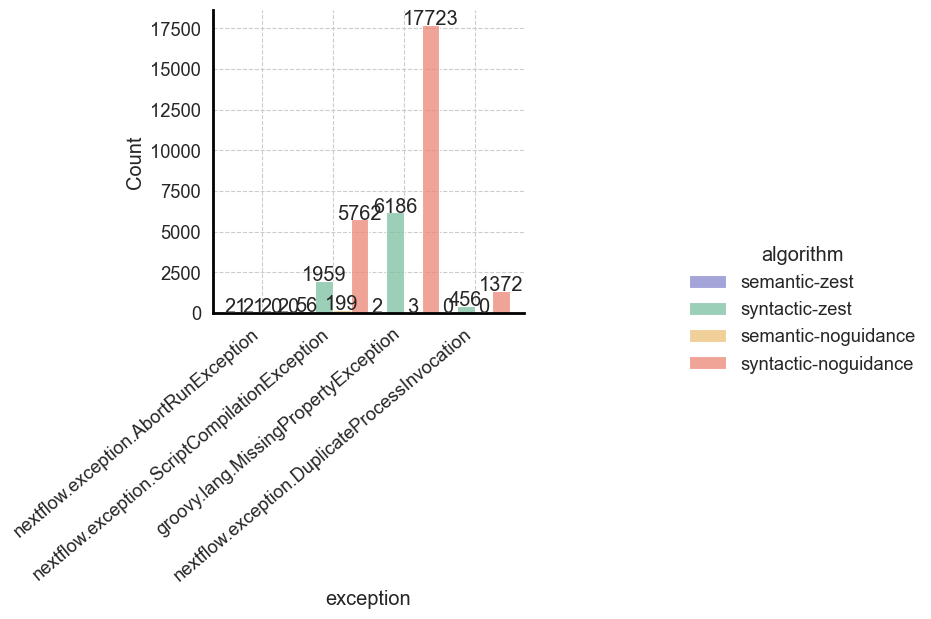

In [29]:
unique=exceptions_data[exceptions_data['unique'] == True]

plot=sns.displot(exceptions_data, x='exception',hue='algorithm', height=4, aspect=1.5, multiple="dodge")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 10
        value = str(int(p.get_height()))
        ax.text(_x, _y, value, ha="center")    


plot.savefig(f'{pdf_dir}/exceptions.pdf')

In [30]:
plot.savefig((os.path.join( pdf_dir, "exceptions_logged.pdf" )))

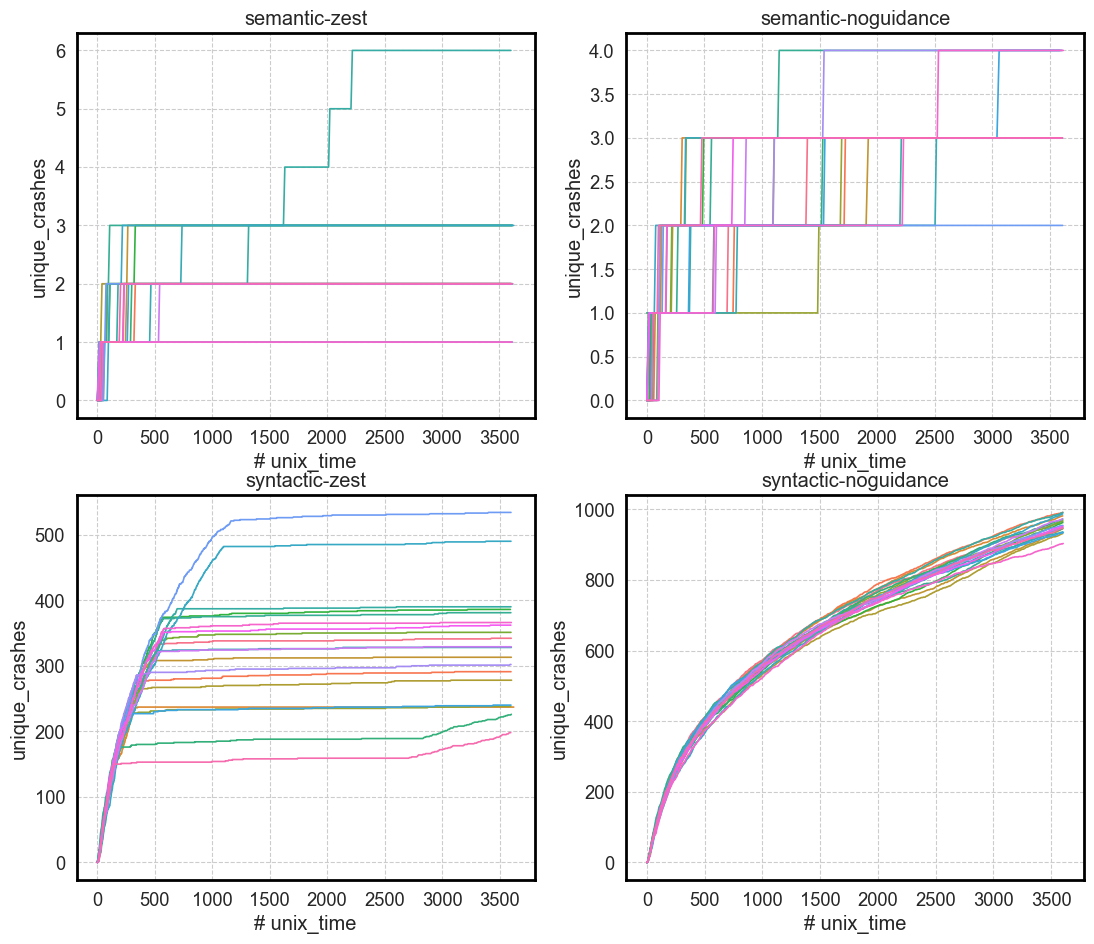

In [31]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(2,2, figsize=(13,11),sharey=False)
i=0
cols = sns.color_palette("husl",20)

algo = 'semantic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)

algo = 'semantic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)


algo = 'syntactic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



algo = 'syntactic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



In [32]:
l.savefig(os.path.join( pdf_dir, "unique_crashes_per_run.pdf" ))

# unix_time unique_crashes


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\2862732193.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


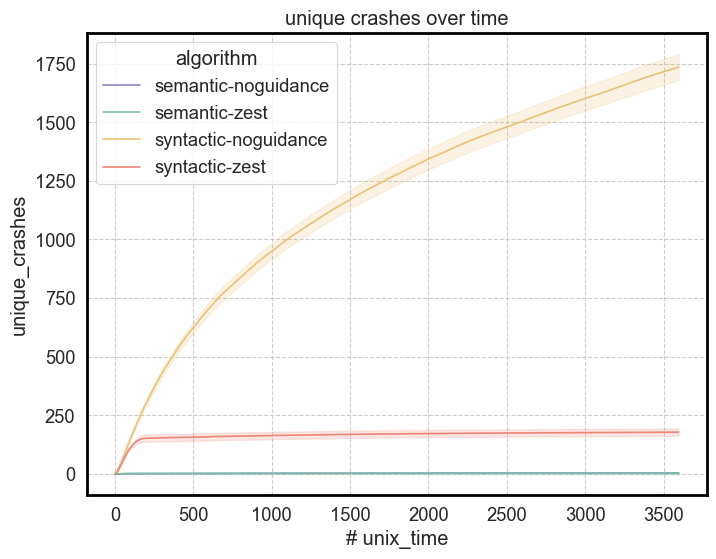

In [101]:
generate_plot_data_base(jqf_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}unique_crashes_over_time.pdf", 'se')


total_inputs unique_crashes


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\873725491.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


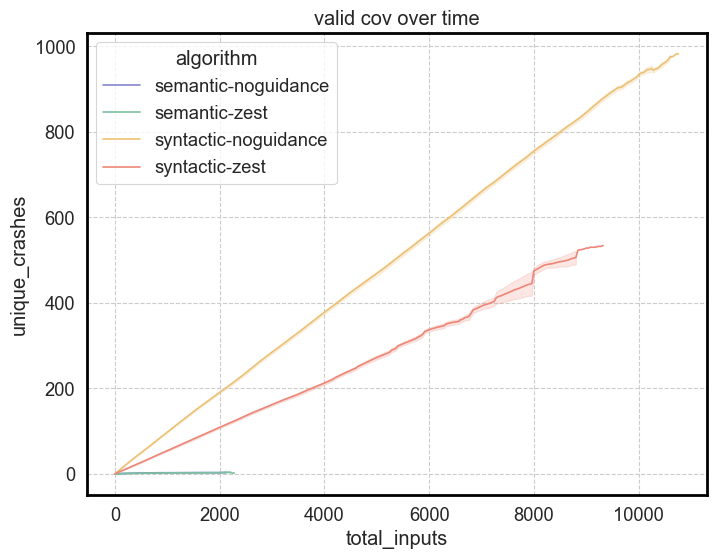

C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,


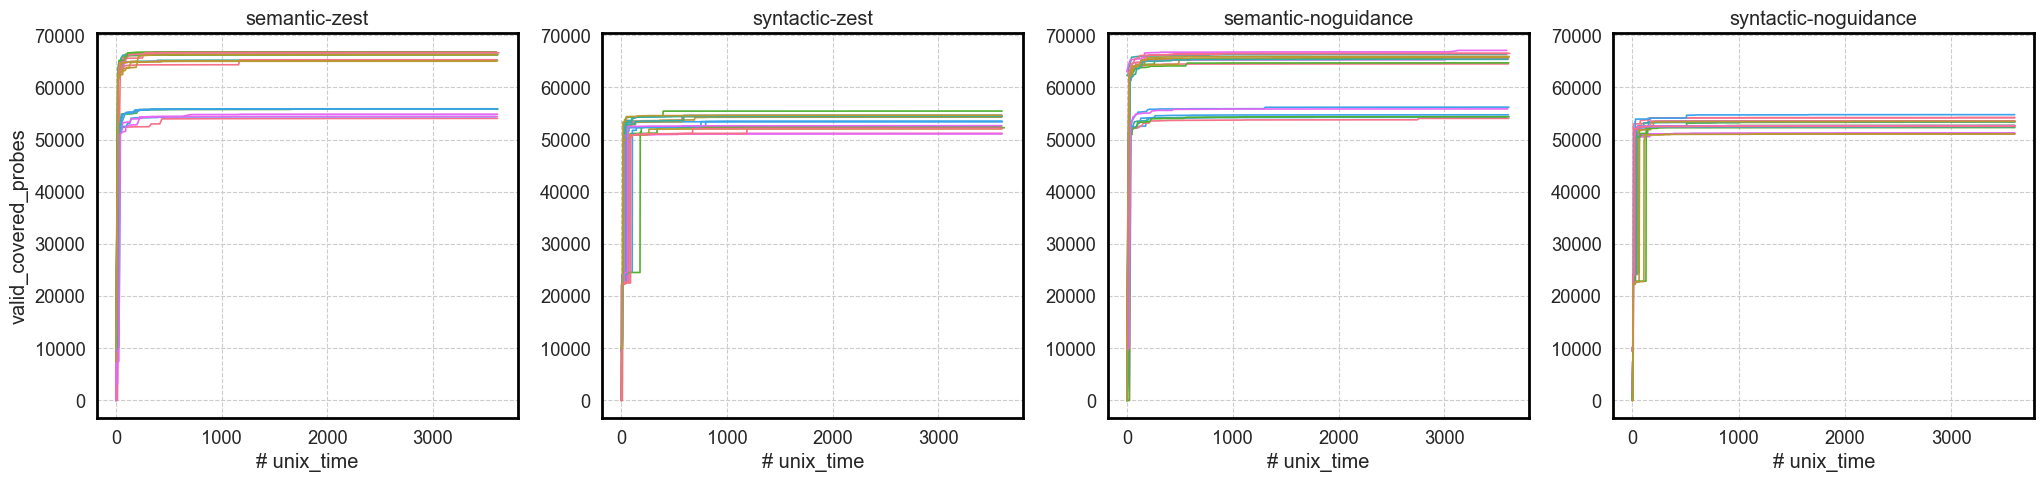

In [35]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run.pdf" ))


C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_19080\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,


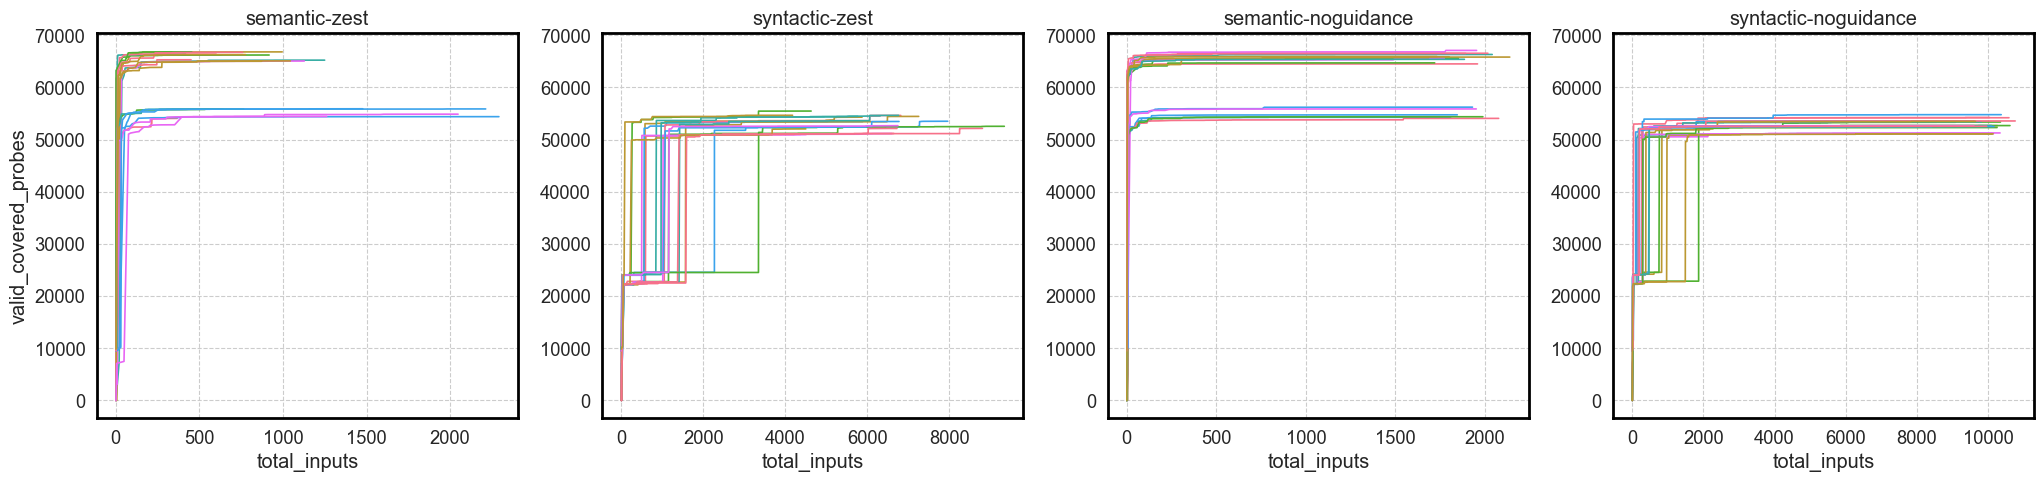

In [36]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_count_based_plot_data[rolling_count_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run_over_inputs.pdf" ))


In [37]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
df1 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('semantic')].groupby(['run','generator'])['valid_inputs_percent'].last()#
#df1 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('semantic')]['valid_inputs_percent']
df2 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('syntactic')].groupby(['run','generator'])['valid_inputs_percent'].last()
#df2 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('syntactic')]['valid_inputs_percent']

print(stats.mannwhitneyu(x=df1, y=df2))

print(df1.describe())
print(df2.describe())



MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [38]:
rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'].str.match('semantic')].groupby(['run','algorithm'])['valid_inputs_percent'].max()

run  algorithm          
0    semantic-noguidance    0.745098
     semantic-zest          0.648501
1    semantic-noguidance    0.666667
     semantic-zest          1.000000
2    semantic-noguidance    0.725490
                              ...   
17   semantic-zest          0.489008
18   semantic-noguidance    1.000000
     semantic-zest          1.000000
19   semantic-noguidance    0.723077
     semantic-zest          1.000000
Name: valid_inputs_percent, Length: 40, dtype: float64

In [39]:
# perform two-sided test. You can use 'greater' or 'less' for one-sided test

d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64
MannwhitneyuResult(statistic=393.0, pvalue=1.9177119523374596e-07)
count       20.000000
mean     61955.750000
std       5413.135144
min      54050.000000
25%      55579.500000
50%      65445.000000
75%      65869.250000
max      67077.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     52710.550000
std       1126.413333
min      51076.000000
25%      52038.250000
50%      52665.500000
75%      53488.500000
max      54764.000000
Name: valid_covered_probes, dtype: float64


In [40]:
d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


MannwhitneyuResult(statistic=272.0, pvalue=0.05310312455977325)
count    20.000000
mean      0.670320
std       0.108717
min       0.489008
25%       0.600413
50%       0.645424
75%       0.717813
max       0.909692
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.592645
std       0.028866
min       0.515747
25%       0.573714
50%       0.594478
75%       0.610904
max       0.632230
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [50]:

d = complete_data_frame
df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())
print(cv(df1))
print(cv(df2))

df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())
print(cv(df1))
print(cv(df2))

MannwhitneyuResult(statistic=205.0, pvalue=0.9031164959895642)
count       20.000000
mean     61627.500000
std       5481.096466
min      54049.000000
25%      55853.250000
50%      65055.000000
75%      66294.250000
max      66801.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     61955.750000
std       5413.135144
min      54050.000000
25%      55579.500000
50%      65445.000000
75%      65869.250000
max      67077.000000
Name: valid_covered_probes, dtype: float64
8.893913376938514
8.73709888824259
MannwhitneyuResult(statistic=239.0, pvalue=0.29767675447218034)
count       20.000000
mean     53225.550000
std       1365.616902
min      51102.000000
25%      52132.500000
50%      53438.000000
75%      54449.000000
max      55456.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     52710.550000
std       1126.413333
min      51076.000000
25%      52038.250000
50%      52665.500000
75%      53488.500000
max      54764.000000
Name:

In [42]:
d=complete_data_frame
a = d[d['algorithm'].str.match('semantic-noguidance')]
b = d[d['algorithm'].str.match('syntactic-noguidance')]

c = d[d['algorithm'].str.match('semantic-zest')]
e = d[d['algorithm'].str.match('syntactic-zest')]

print(a['valid_inputs_percent'].std()) 
print(a.groupby(['run'])['valid_inputs_percent'].last().describe()) 


print(b['valid_inputs_percent'].std())
print(b.groupby(['run'])['valid_inputs_percent'].last().describe())






0.0459383865094238
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
0.015830715199745715
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [43]:
d= complete_data_frame
d[d['algorithm'].str.match('syntactic-noguidance')]['valid_inputs_percent'].std()


0.015830715199745715

In [44]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100


In [48]:
for algo in ALGORITHM:
    b =complete_data_frame[complete_data_frame['algorithm'].str.match(algo)]

    total = b.groupby(['run'])['total_inputs'].last()
    val = b.groupby(['run'])['valid_inputs'].last() 
    valper = b.groupby(['run'])['valid_inputs_percent'].last()

    total_mean  = total.mean()
    val_mean= val.mean()
    valper_mean = valper.mean()

    total_std = cv(total)
    val_std = cv(val)
    valper_std = cv(valper)
    
    print(f"{algo} & {total_mean:.0f} ({total_std:.2f}\%) &  {val_mean:.0f} ({val_std:.2f}\%) & {valper_mean*100:.2f} ({valper_std:.2f}\%) ")
    
    


semantic-zest & 1036 (56.01\%) &  662 (50.11\%) & 67.03 (16.22\%) 
syntactic-zest & 6412 (20.67\%) &  3801 (21.58\%) & 59.26 (4.87\%) 
semantic-noguidance & 1890 (6.69\%) &  1174 (6.62\%) & 62.12 (1.75\%) 
syntactic-noguidance & 10152 (3.15\%) &  5097 (3.45\%) & 50.20 (1.11\%) 
afl & nan (nan\%) &  nan (nan\%) & nan (nan\%) 


In [46]:
d = complete_data_frame
for algo in ALGORITHM:
    b = d[d['algorithm'].str.match(algo)]
    total = b.groupby(['run'])['all_covered_probes'].last()
    val = b.groupby(['run'])['valid_covered_probes'].last() 
   
    total_mean  = total.mean()
    val_mean= val.mean()
 

    total_std = cv(total)
    val_std = cv(val)
   
    
    print(f"{algo} & {total_mean:.2f} ({total_std:.2f}\%) &  {val_mean:.2f} ({val_std:.2f}\%) ")
    
    


semantic-zest & 63656.60 (8.37\%) &  61627.50 (8.89\%) 
syntactic-zest & 54996.90 (1.97\%) &  53225.55 (2.57\%) 
semantic-noguidance & 64037.90 (8.42\%) &  61955.75 (8.74\%) 
syntactic-noguidance & 54867.25 (1.86\%) &  52710.55 (2.14\%) 
afl & nan (nan\%) &  nan (nan\%) 


In [47]:
data = complete_data_frame[complete_data_frame['algorithm']=='semantic-zest']
print(data.groupby(['run','algorithm'])['total_inputs'].max())


run  algorithm    
0    semantic-zest     367
1    semantic-zest     995
2    semantic-zest     917
3    semantic-zest    1249
4    semantic-zest    2291
5    semantic-zest    1127
6    semantic-zest     450
7    semantic-zest    1044
8    semantic-zest     641
9    semantic-zest     417
10   semantic-zest    2212
11   semantic-zest    1261
12   semantic-zest     600
13   semantic-zest     872
14   semantic-zest     454
15   semantic-zest     765
16   semantic-zest    1477
17   semantic-zest    2047
18   semantic-zest     759
19   semantic-zest     776
Name: total_inputs, dtype: int64


<Axes: xlabel='# unix_time', ylabel='map_size'>

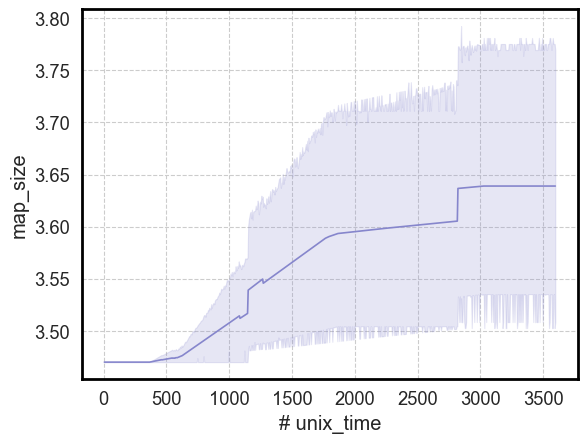

In [116]:
sns.lineplot(data=afl_time_based_plot_data, x='# unix_time', y='map_size')